In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../data")
df = pd.read_csv(os.path.join(output_dir, "combined_csv.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 3].index)
df.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,0.257392,0.000089,0.0,33951.288889,0.066471,15747.533333,54180.222222,1.0,426.0,0.107691,6.0,11.811111,1.240458e+10,37.251644
1,0.348676,0.000000,0.0,14745.600000,0.076580,13445.644444,48827.111111,1.0,854.0,0.107901,6.0,10.716667,1.240458e+10,37.440750
2,1.103442,0.000000,0.0,14290.488889,0.076580,15635.400000,52507.400000,1.0,1420.0,0.103107,6.0,10.716667,1.240458e+10,37.440750
3,1.328542,0.000089,0.0,24576.000000,0.082302,13571.600000,48802.888889,1.0,2018.0,0.108230,6.0,12.738889,1.240458e+10,36.465056
4,2.251209,0.000089,0.0,11741.866667,0.082302,15876.311111,54117.933333,1.0,2645.0,0.102428,6.0,12.738889,1.240458e+10,36.465056


In [3]:
df_t = pd.DataFrame()

In [4]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*df['totalcpu'])/100
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
df_t['replica'] = df['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests,replica
0,0.708667,462.090854,0.107691,426.0,1.0
1,0.643000,464.436634,0.107901,854.0,1.0
2,0.643000,464.436634,0.103107,1420.0,1.0
3,0.764333,452.333568,0.108230,2018.0,1.0
4,0.764333,452.333568,0.102428,2645.0,1.0


In [5]:
column_indices = {name: i for i, name in enumerate(df_t.columns)}
#Length of df
n = len(df_t)

# df split
train_df = df_t[0:int(n*0.7)]
val_df = df_t[int(n*0.7):int(n*0.9)]
test_df = df_t[int(n*0.9):]

# number of features for keras 

num_features = df_t.shape[1]

# Normalize the data

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
train_df.head()

,total_cpu_util,total_mem_util,responsetime,requests,replica
0,-1.286347,-1.660565,-0.264628,-1.278581,-0.858042
1,-1.298406,-1.639716,-0.263152,-1.268944,-0.858042
2,-1.298406,-1.639716,-0.296829,-1.256200,-0.858042
3,-1.276125,-1.747286,-0.260841,-1.242736,-0.858042
4,-1.276125,-1.747286,-0.301597,-1.228619,-0.858042


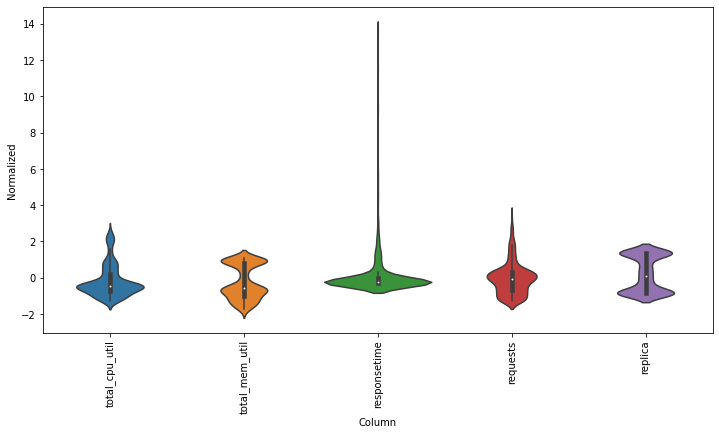

In [6]:
# Normalized Plot

df_std = (df_t - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_t.keys(), rotation=90)

In [7]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    print(self.input_slice)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    print(self.input_indices)

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [8]:
#w1 = WindowGenerator(input_width=400, label_width=1, shift=400,
#                     label_columns=['responsetime'])
#w1

In [9]:
w2 = WindowGenerator(input_width=100, label_width=1, shift=1,
                     label_columns=['responsetime'])
w2

slice(0, 100, None)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


Total window size: 101
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Label indices: [100]
Label column name(s): ['responsetime']

In [10]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [11]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 101, 5)
Inputs shape: (3, 100, 5)
labels shape: (3, 1, 1)


In [12]:
w2.example = example_inputs, example_labels

In [13]:
def plot(self, model=None, plot_col='responsetime', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

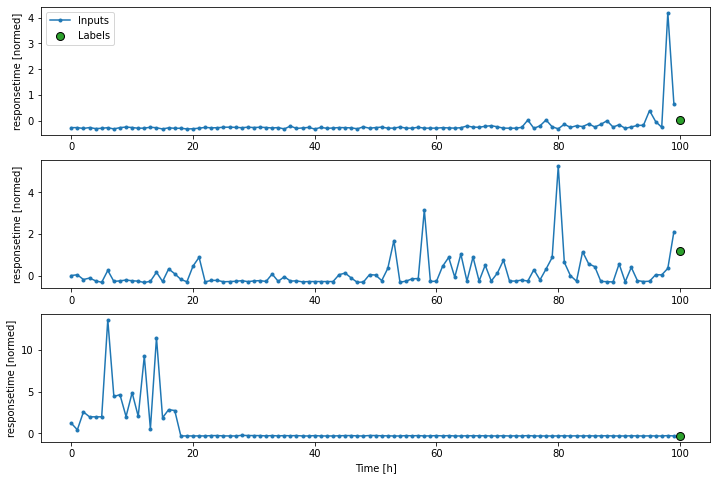

In [14]:
w2.plot()

In [15]:
#  Create tf.data.Datasets

In [16]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [18]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 100, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [19]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 100, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [20]:
# Single step models

In [21]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['responsetime'])
single_step_window



slice(0, 1, None)
[0]


Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['responsetime']

In [22]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [23]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [24]:
baseline = Baseline(label_index=column_indices['responsetime'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

7/7 [==============================] - 0s 1ms/step - loss: 1.0426 - mean_absolute_error: 0.5186


In [25]:
wide_window = WindowGenerator(
    input_width=100, label_width=100, shift=1,
    label_columns=['responsetime'])

wide_window

slice(0, 100, None)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


Total window size: 101
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Label indices: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
Label column name(s): ['responsetime']

In [26]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


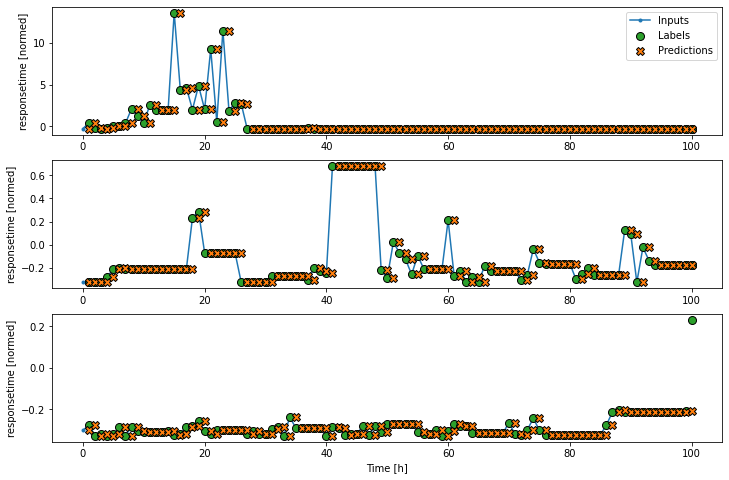

In [27]:
wide_window.plot(baseline)

In [28]:
# Linear model

In [29]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [30]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


In [31]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [32]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
24/24 [==============================] - 0s 15ms/step - loss: 2.8864 - mean_absolute_error: 1.2135 - val_loss: 4.9869 - val_mean_absolute_error: 1.8358
Epoch 2/20
24/24 [==============================] - 0s 9ms/step - loss: 2.7512 - mean_absolute_error: 1.1765 - val_loss: 4.7457 - val_mean_absolute_error: 1.7792
Epoch 3/20
24/24 [==============================] - 0s 10ms/step - loss: 2.6246 - mean_absolute_error: 1.1406 - val_loss: 4.5353 - val_mean_absolute_error: 1.7290
Epoch 4/20
24/24 [==============================] - 0s 7ms/step - loss: 2.5075 - mean_absolute_error: 1.1064 - val_loss: 4.3201 - val_mean_absolute_error: 1.6760
Epoch 5/20
24/24 [==============================] - 0s 10ms/step - loss: 2.3971 - mean_absolute_error: 1.0732 - val_loss: 4.1267 - val_mean_absolute_error: 1.6277
Epoch 6/20
24/24 [==============================] - 0s 7ms/step - loss: 2.2954 - mean_absolute_error: 1.0413 - val_loss: 3.9378 - val_mean_absolute_error: 1.5797
Epoch 7/20
24/24 [=======

In [33]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 100, 5)
Output shape: (32, 100, 1)


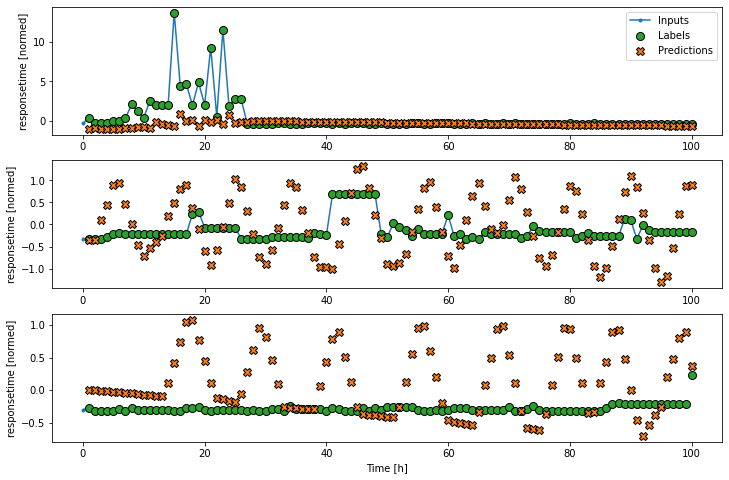

In [34]:
wide_window.plot(linear)

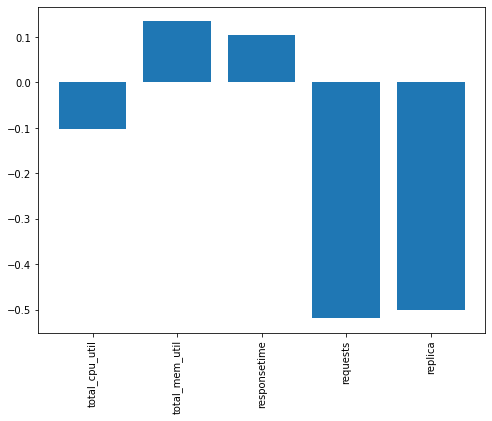

In [35]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [36]:
# Dense

In [37]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
24/24 [==============================] - 0s 13ms/step - loss: 0.9135 - mean_absolute_error: 0.3805 - val_loss: 0.8741 - val_mean_absolute_error: 0.5586
Epoch 2/20
24/24 [==============================] - 0s 10ms/step - loss: 0.7770 - mean_absolute_error: 0.2975 - val_loss: 0.7450 - val_mean_absolute_error: 0.5506
Epoch 3/20
24/24 [==============================] - 0s 9ms/step - loss: 0.7469 - mean_absolute_error: 0.2700 - val_loss: 0.6978 - val_mean_absolute_error: 0.5320
Epoch 4/20
24/24 [==============================] - 0s 16ms/step - loss: 0.7237 - mean_absolute_error: 0.2858 - val_loss: 0.6859 - val_mean_absolute_error: 0.5291
Epoch 5/20
24/24 [==============================] - 0s 6ms/step - loss: 0.7117 - mean_absolute_error: 0.2668 - val_loss: 0.6779 - val_mean_absolute_error: 0.5283
Epoch 6/20
24/24 [==============================] - 0s 7ms/step - loss: 0.6989 - mean_absolute_error: 0.2582 - val_loss: 0.6578 - val_mean_absolute_error: 0.5152
Epoch 7/20
24/24 [=======

In [38]:
CONV_WIDTH = 100
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['responsetime'])

conv_window

slice(0, 100, None)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


Total window size: 101
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Label indices: [100]
Label column name(s): ['responsetime']

Text(0.5, 1.0, 'Given 100 data as input, predict 100 data into the future.')

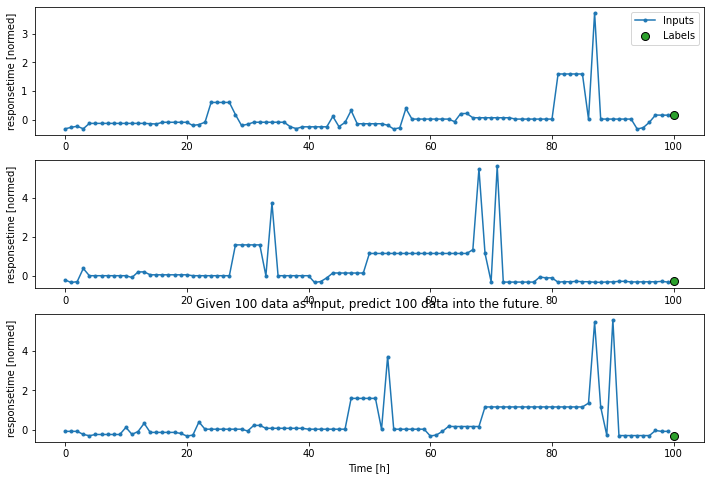

In [39]:
conv_window.plot()
plt.title("Given 100 data as input, predict 100 data into the future.")

In [40]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [41]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 100, 5)
Output shape: (32, 1, 1)


In [42]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

4/4 [==============================] - 0s 2ms/step - loss: 1.0833 - mean_absolute_error: 0.7546


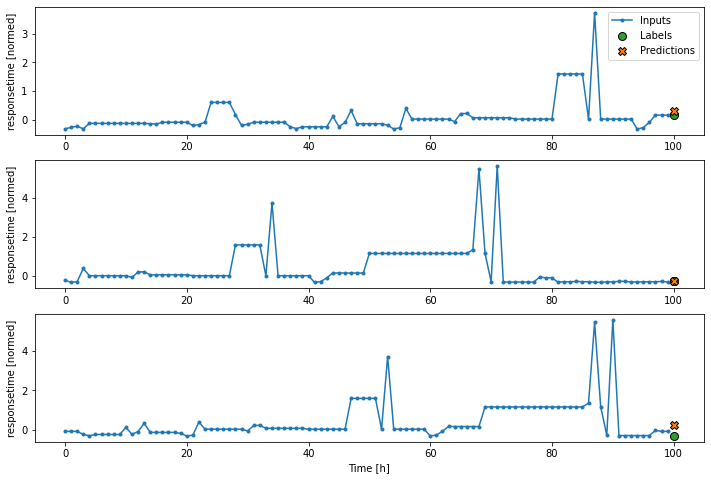

In [43]:
conv_window.plot(multi_step_dense)

In [44]:
# Convolution neural network

In [45]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [46]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 100, 5)
Output shape: (32, 1, 1)


In [47]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

4/4 [==============================] - 0s 2ms/step - loss: 1.2791 - mean_absolute_error: 0.7355


In [48]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 100, 5)
Labels shape: (32, 100, 1)
Output shape: (32, 1, 1)


In [49]:
LABEL_WIDTH = 100
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['responsetime'])

wide_conv_window

slice(0, 199, None)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198]


Total window size: 200
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198]
Label indices: [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 

In [50]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 199, 5)
Labels shape: (32, 100, 1)
Output shape: (32, 100, 1)


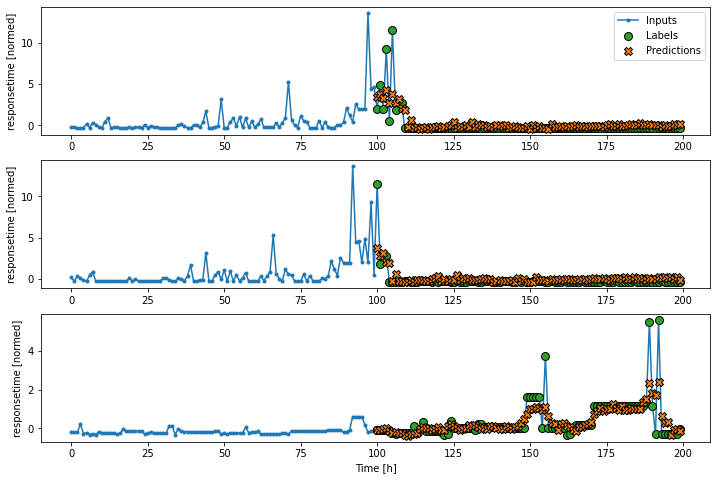

In [51]:
wide_conv_window.plot(conv_model)

In [52]:
# Recurrent neural network

In [53]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [54]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 100, 5)
Output shape: (32, 100, 1)


In [55]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

4/4 [==============================] - 0s 10ms/step - loss: 0.6631 - mean_absolute_error: 0.5883


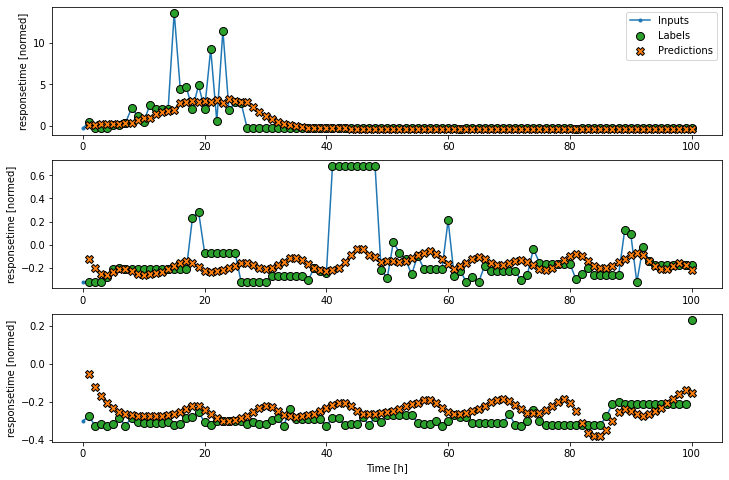

In [56]:
wide_window.plot(lstm_model)

In [57]:
# Performance

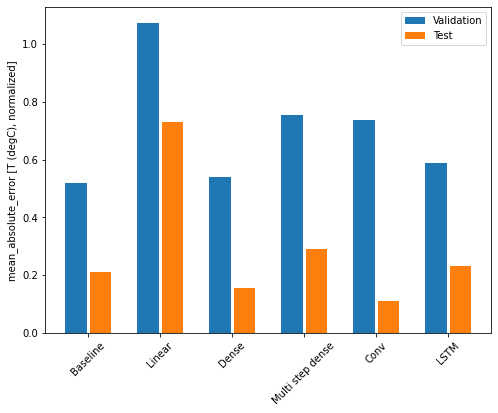

In [58]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
